# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Load data & Merge data frame

In [5]:

file_path = '/content/E-commerce_data.xlsx'
customers_df = pd.read_excel(file_path, 'customers')
genders_df = pd.read_excel(file_path, 'genders')
cities_df = pd.read_excel(file_path, 'cities')
transactions_df = pd.read_excel(file_path, 'transactions')
branches_df = pd.read_excel(file_path, 'branches')
merchants_df = pd.read_excel(file_path, 'merchants')

customers_df = customers_df.merge(genders_df, on='gender_id').merge(cities_df, on='city_id')
transactions_df = transactions_df.merge(customers_df, on='customer_id').merge(branches_df, on='branch_id')
transactions_df = transactions_df.merge(merchants_df, on='merchant_id')

# Plot customer demographics


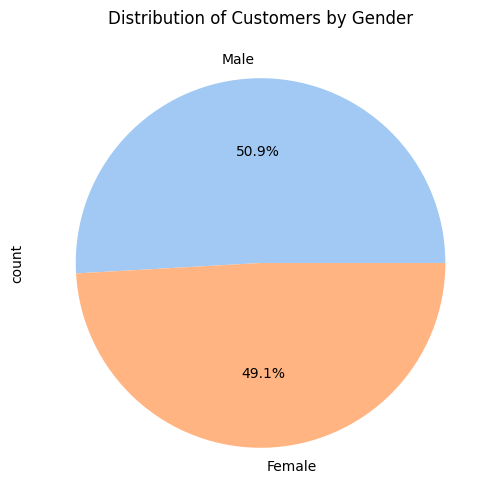

<ipython-input-7-26569b34d315>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')


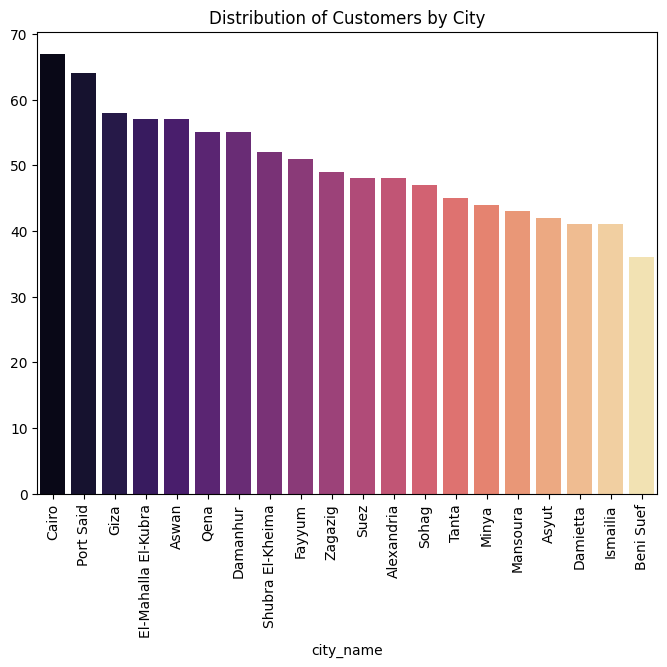

In [7]:
def plot_demographics(customers_df):
    plt.figure(figsize=(6, 6))
    gender_counts = customers_df['gender_name'].value_counts()
    gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title('Distribution of Customers by Gender')
    plt.show()

    plt.figure(figsize=(8, 6))
    city_counts = customers_df['city_name'].value_counts()
    sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')
    plt.title('Distribution of Customers by City')
    plt.xticks(rotation=90)
    plt.show()

plot_demographics(customers_df)



# Plot coupon usage over time

<Figure size 1000x600 with 0 Axes>

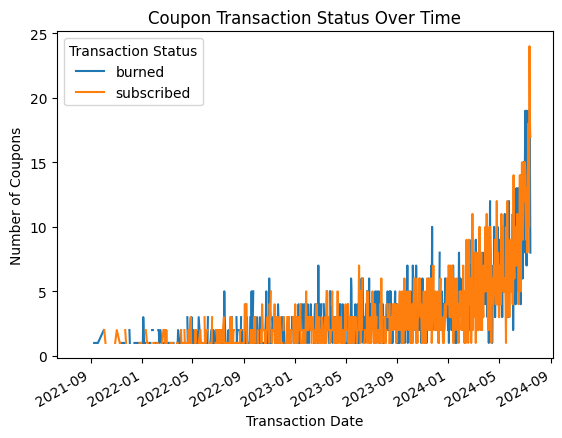

In [15]:
def plot_coupon_usage(transactions_df):

    transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
    transactions_df['burn_date'] = pd.to_datetime(transactions_df['burn_date'])
    status_counts = transactions_df.groupby(['transaction_date', 'transaction_status']).size().unstack()
    custom_colors = ['#1f77b4', '#ff7f0e']
    plt.figure(figsize=(10, 6))
    status_counts.plot(kind='line', color=custom_colors)
    plt.title('Coupon Transaction Status Over Time')
    plt.ylabel('Number of Coupons')
    plt.xlabel('Transaction Date')
    plt.legend(title='Transaction Status')
    plt.show()

plot_coupon_usage(transactions_df)


# Plot top-performing cities and branches

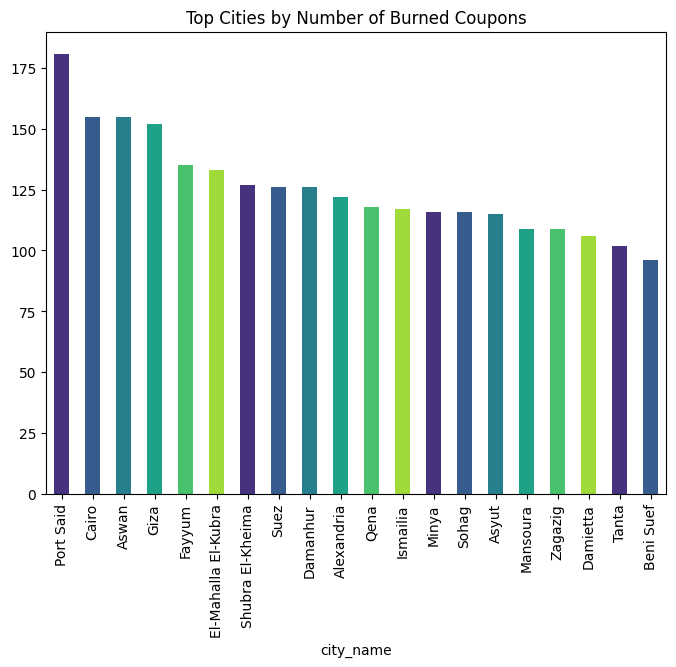

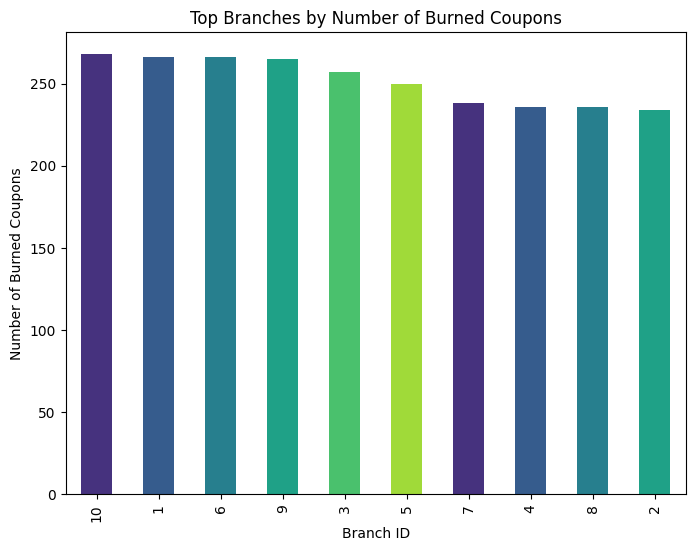

In [16]:

def plot_top_performers(transactions_df):
    burns_by_city = transactions_df[transactions_df['transaction_status'] == 'burned'].groupby('city_name').size()
    if not burns_by_city.empty:
        plt.figure(figsize=(8, 6))
        burns_by_city.sort_values(ascending=False).plot(kind='bar', color=sns.color_palette('viridis'))
        plt.title('Top Cities by Number of Burned Coupons')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print("No data available for burned coupons by city to display")

    burns_by_branch = transactions_df[transactions_df['transaction_status'] == 'burned'].groupby('branch_id').size()
    if not burns_by_branch.empty:
        plt.figure(figsize=(8, 6))
        burns_by_branch.sort_values(ascending=False).plot(kind='bar', color=sns.color_palette('viridis'))
        plt.title('Top Branches by Number of Burned Coupons')
        plt.xlabel('Branch ID')
        plt.ylabel('Number of Burned Coupons')
        plt.show()
    else:
        print("No data available for burned coupons by branch to display")

plot_top_performers(transactions_df)

# Prepare data for clustering

In [17]:

def prepare_data(df):
    customer_features = df.groupby('customer_id').agg({
        'transaction_id': 'count',
        'burn_date': lambda x: x.notnull().sum(),
        'city_id': 'first',
        'gender_id': 'first'
    }).reset_index()

    customer_features['city_id'] = customer_features['city_id'].astype('category').cat.codes
    customer_features['gender_id'] = customer_features['gender_id'].astype('category').cat.codes

    return customer_features

customer_features = prepare_data(transactions_df)



# Train and evaluate KMeans clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette score is 0.25, and inertia is 2860.03


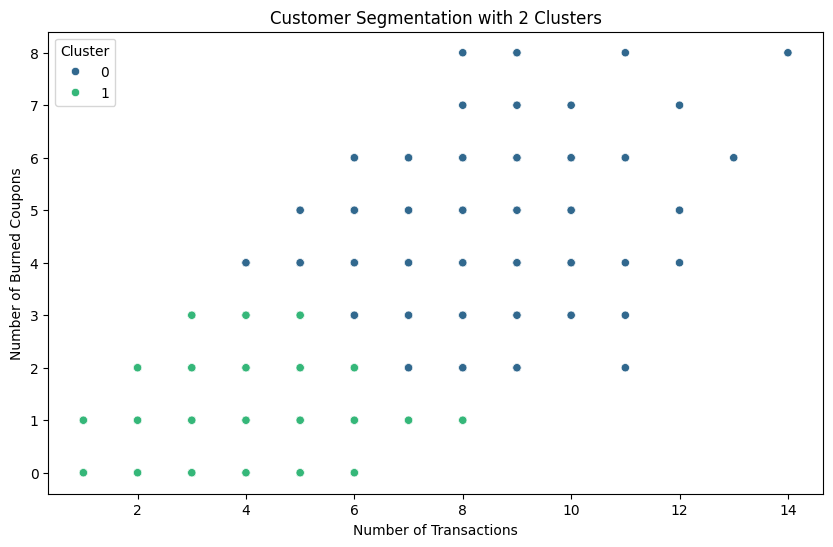

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette score is 0.29, and inertia is 2191.79


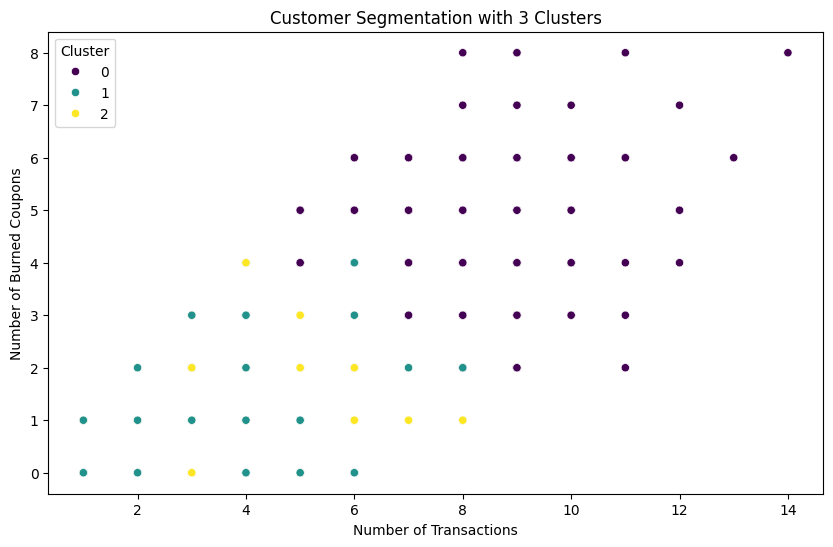

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette score is 0.28, and inertia is 1860.03


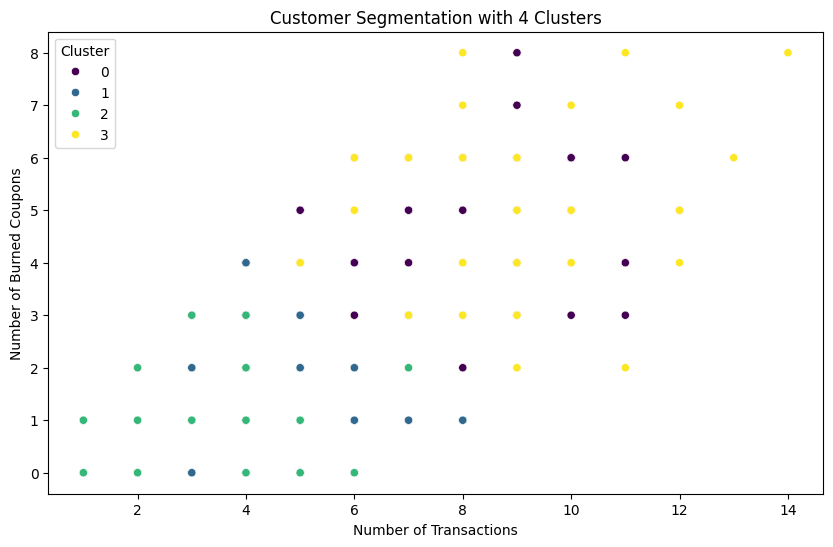

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette score is 0.30, and inertia is 1562.21


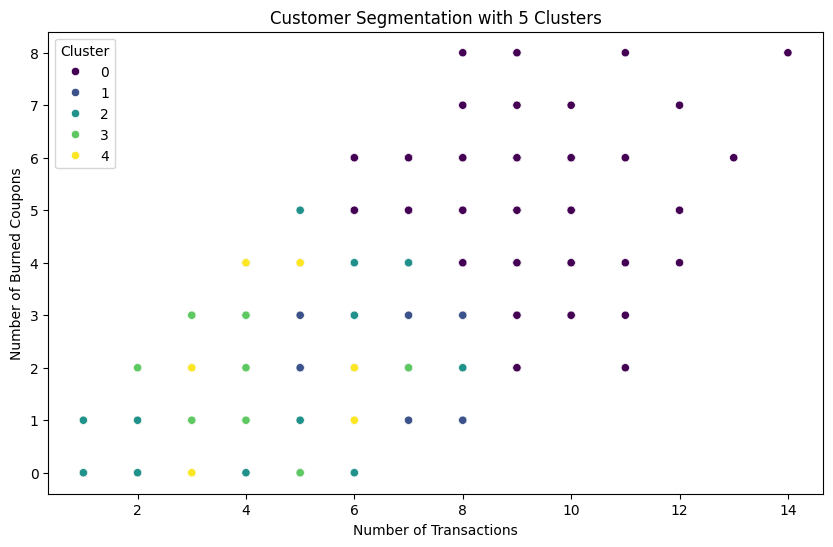

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_kmeans(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[['transaction_id', 'burn_date', 'city_id', 'gender_id']])

    for n_clusters in range(2, 6):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(scaled_data)
        silhouette_avg = silhouette_score(scaled_data, clusters)
        inertia = kmeans.inertia_
        print(f'For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.2f}, and inertia is {inertia:.2f}')

        data['cluster'] = clusters

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='transaction_id', y='burn_date', hue='cluster', palette='viridis', data=data)
        plt.title(f'Customer Segmentation with {n_clusters} Clusters')
        plt.xlabel('Number of Transactions')
        plt.ylabel('Number of Burned Coupons')
        plt.legend(title='Cluster')
        plt.show()
train_and_evaluate_kmeans(customer_features)


Sample Data:
    customer_id  transaction_id  burn_date  city_id  gender_id  cluster
0            1               7          3        6          0        0
1            2               3          1       19          1        3
2            3               5          1       14          0        1
3            4               1          0       10          1        3
4            5               4          3        7          0        4
Cluster Analysis:
    cluster  transaction_id  burn_date  customer_id
0        0        8.140000   4.620000          200
1        1        4.609890   2.071429          182
2        2        4.733645   2.275701          214
3        3        4.135000   1.990000          200
4        4        3.590674   1.709845          193
Cluster 0.0 has 200.0 customers with average 8.14 transactions and 4.62 burned coupons.
This cluster has low engagement. Consider increasing promotional efforts.
Cluster 1.0 has 182.0 customers with average 4.6098901098901095 transacti

<ipython-input-35-1b6b0ae4b9cc>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=data, palette='viridis')


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

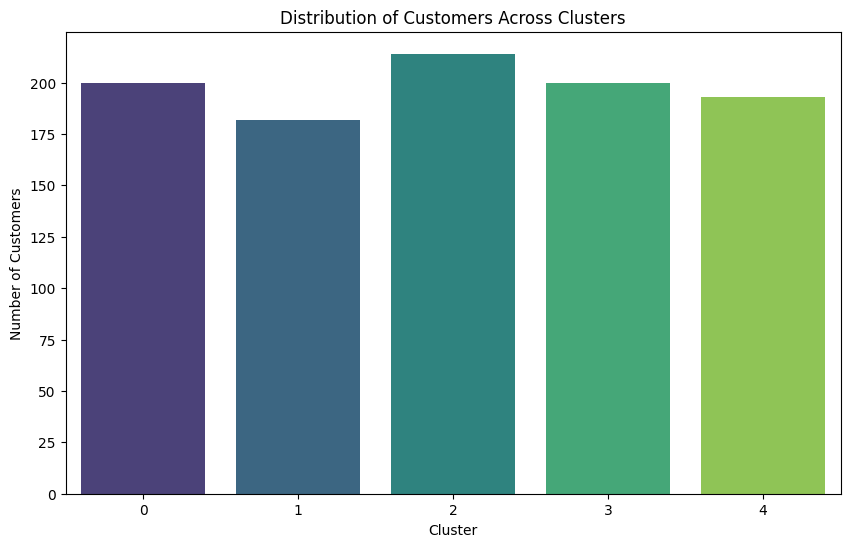

In [35]:
def analyze_and_plot_clusters(data):
    if 'cluster' not in data.columns:
        print("The 'cluster' column is missing in the data.")
        return

    # Display some sample data
    print("Sample Data:\n", data.head())

    # Analyze each cluster
    cluster_analysis = data.groupby('cluster').agg({
        'transaction_id': 'mean',
        'burn_date': 'mean',
        'customer_id': 'count'
    }).reset_index()

    if cluster_analysis.empty:
        print("No clusters found or the cluster analysis returned empty.")
        return

    # Print cluster analysis
    print("Cluster Analysis:\n", cluster_analysis)

    # Provide recommendations based on analysis
    for idx, row in cluster_analysis.iterrows():
        print(f"Cluster {row['cluster']} has {row['customer_id']} customers with average {row['transaction_id']} transactions and {row['burn_date']} burned coupons.")
        if row['transaction_id'] > 10:
            print("This cluster is highly engaged. Consider offering exclusive discounts.")
        else:
            print("This cluster has low engagement. Consider increasing promotional efforts.")
            plt.figure(figsize=(10, 6))
    sns.countplot(x='cluster', data=data, palette='viridis')
    plt.title('Distribution of Customers Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    plt.show()

analyze_and_plot_clusters(customer_features)
